## PCA for Feature Engineering

There are two ways you could use PCA for feature engineering

1. Descriptive Technique
2. Components themselves as features
   * **Dimensionality Reduction**: When your features are highly redudant(multicollinear, specifically), PCA will partition out the redundancy into one or more near-zero variance components, Which you can then drop since they will contain litter or no information.
   * **Anomaly Detection**: nusual variation, not apparent from the original features, will often show up in the low-variance components. These components could be highly informative in an anomaly or outlier detection task.
   * **Noise reduction**:  collection of sensor readings will often share some common background noise. PCA can sometimes collect the (informative) signal into a smaller number of features while leaving the noise alone, thus boosting the signal-to-noise ratio.
   * **Decorrelation**:Some ML algorithms struggle with highly-correlated features. PCA transforms correlated features into uncorrelated components, which could be easier for your algorithm to work with
   
**PCA Best Practices**

There are a few things to keep in mind when applying PCA:
* PCA only works with numeric features, like continous quantities or counts.
* PCA is sensitive to scale. It's good practice to standardize your data before applying PCA, unless you know you have good reason not to.
* Consider removing or constanining outliers, since they can an have an undue influence on the results

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from sklearn.feature_selection import mutual_info_regression


plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)


def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


df = pd.read_csv("autos.csv")

In [4]:
features = ["highway_mpg", "engine_size", "horsepower", "curb_weight"]

X = df.copy()
y = X.pop('price')
X = X.loc[:, features]

# Standardize
X_scaled = (X - X.mean(axis=0)) / X.std(axis=0)

In [7]:
df[['highway_mpg','engine_size','horsepower','curb_weight']]

,highway_mpg,engine_size,horsepower,curb_weight
0,27,130,111,2548
1,27,130,111,2548
2,26,152,154,2823
3,30,109,102,2337
4,22,136,115,2824
...,...,...,...,...
188,28,141,114,2952
189,25,141,160,3049
190,23,173,134,3012
191,27,145,106,3217


In [5]:
X_scaled

,highway_mpg,engine_size,horsepower,curb_weight
0,-0.555613,0.045098,0.198054,-0.025646
1,-0.555613,0.045098,0.198054,-0.025646
2,-0.702307,0.574066,1.330822,0.496473
3,-0.115531,-0.459826,-0.039037,-0.426254
4,-1.289083,0.189362,0.303427,0.498371
...,...,...,...,...
188,-0.408919,0.309582,0.277084,0.741394
189,-0.849001,0.309582,1.488882,0.925560
190,-1.142389,1.078989,0.803953,0.855311
191,-0.555613,0.405758,0.066336,1.244527


In [8]:
from sklearn.decomposition import PCA

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

X_pca.head()

,PC1,PC2,PC3,PC4
0,0.382486,-0.400222,0.124122,0.169539
1,0.382486,-0.400222,0.124122,0.169539
2,1.550890,-0.107175,0.598361,-0.256081
3,-0.408859,-0.425947,0.243335,0.013920
4,1.132749,-0.814565,-0.202885,0.224138


In [10]:
loadings = pd.DataFrame(pca.components_.T,
                       columns=component_names,
                       index=X.columns)
loadings

,PC1,PC2,PC3,PC4
highway_mpg,-0.492347,0.770892,0.070142,-0.397996
engine_size,0.503859,0.626709,0.019960,0.594107
horsepower,0.500448,0.013788,0.731093,-0.463534
curb_weight,0.503262,0.113008,-0.678369,-0.523232


array([<AxesSubplot:title={'center':'% Explained Variance'}, xlabel='Component'>,
       <AxesSubplot:title={'center':'% Cumulative Variance'}, xlabel='Component'>],
      dtype=object)

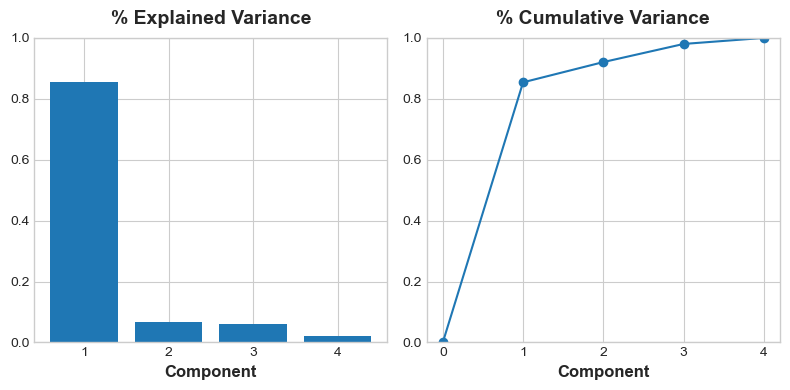

In [11]:
plot_variance(pca)

In [12]:
mi_scores = make_mi_scores(X_pca, y, discrete_features=False)
mi_scores

PC1    1.014583
PC2    0.378939
PC3    0.307230
PC4    0.204729
Name: MI Scores, dtype: float64

In [13]:
# Show dataframe sorted by PC3
idx = X_pca["PC3"].sort_values(ascending=False).index
cols = ["make", "body_style", "horsepower", "curb_weight"]
df.loc[idx, cols]

,make,body_style,horsepower,curb_weight
117,porsche,hardtop,207,2756
118,porsche,hardtop,207,2756
119,porsche,convertible,207,2800
45,jaguar,sedan,262,3950
96,nissan,hatchback,200,3139
...,...,...,...,...
59,mercedes-benz,wagon,123,3750
61,mercedes-benz,sedan,123,3770
101,peugot,wagon,95,3430
105,peugot,wagon,95,3485


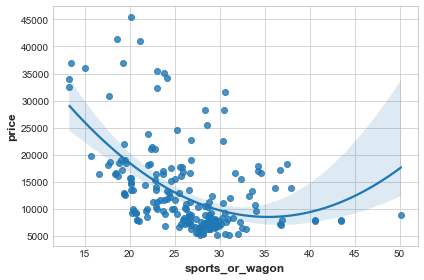

In [14]:
df["sports_or_wagon"] = X.curb_weight / X.horsepower
sns.regplot(x="sports_or_wagon", y='price', data=df, order=2);